In [1]:
import os
import DataProcess
import MLP_Model

2023-10-25 21:10:46.703489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-25 21:10:46.706589: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
cwd = '/home/jovyan/Snow-Extrapolation/contributors/team_member_savalan'
datapath = '/home/jovyan/Snow-Extrapolation'

In [3]:
#Define hold out year
HOY = 2019
#Run data processing script to partition key regional dataframes
#note, need to load RegionTrain_SCA.h5,
RegionTrain, RegionTest, RegionObs_Train, RegionObs_Test, RegionTest_notScaled = DataProcess.DataProcess(HOY, datapath, cwd)

Processing training dataframes for each region
N_Sierras
S_Sierras_Low
S_Sierras_High


In [7]:
#model training, each participants model will be different but should follow the prescribed input feature template
epochs= 30
Predictions = MLP_Model.Model_train(cwd, epochs, RegionTrain, RegionTest, RegionObs_Train, RegionObs_Test, RegionTest_notScaled)

Training model for:  N_Sierras
All previous files deleted successfully.
(750, 1, 105)
8/8 [==============================] - 1s 14ms/step
Training model for:  S_Sierras_Low
All previous files deleted successfully.
(838, 1, 6)
9/9 [==============================] - 1s 14ms/step
Training model for:  S_Sierras_High
All previous files deleted successfully.
(1632, 1, 40)
18/18 [==============================] - 0s 4ms/step


Preliminary Model Analysis for:  N_Sierras
 R2 is  0.9740284351911367
 RMSE is  5.870539773884877
 R2 fSCA is  0.9529414693359088
 RMSE fSCA is  7.902202556304827


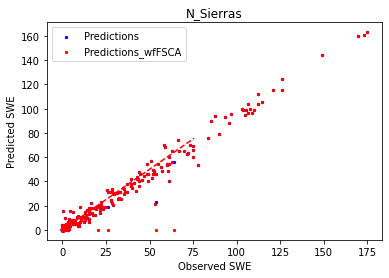

Preliminary Model Analysis for:  S_Sierras_Low
 R2 is  0.9799895297298865
 RMSE is  3.569375716979207
 R2 fSCA is  0.8687142108540226
 RMSE fSCA is  9.14265804760441


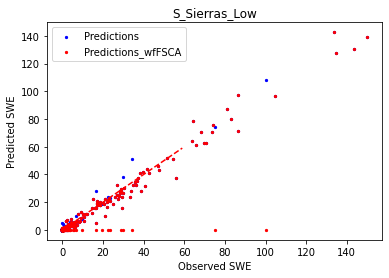

Preliminary Model Analysis for:  S_Sierras_High
 R2 is  0.9855154031491571
 RMSE is  5.645735059117851
 R2 fSCA is  0.9732492729053396
 RMSE fSCA is  7.672467956025577


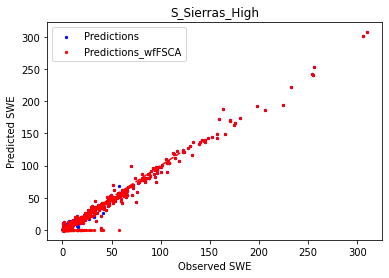

,Region,R2,RMSE,R2_fSCA,RMSE_fSCA
0,N_Sierras,0.97,5.87,0.95,7.9
1,S_Sierras_Low,0.98,3.57,0.87,9.14
2,S_Sierras_High,0.99,5.65,0.97,7.67


In [8]:
Performance = MLP_Model.Prelim_Eval(cwd, Predictions)
Performance

In [6]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import time
import re
import copy
import numpy as np
import pandas as pd
import h5py
import tables
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle 
import sklearn
from pickle import dump
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import threading  # this is the threading library
import warnings; warnings.filterwarnings("ignore")

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    float regex comes from https://stackoverflow.com/a/12643073/190597
    '''
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]




Predictions = {}

#Get regions
Regions = list(RegionTest.keys())

for Region in Regions:
    print(Region)

    #set up test dfs
    X_test = RegionTest[Region].copy()
    X_test_notscaled = RegionTest_notScaled[Region]
    y_test = RegionObs_Test[Region].copy()

    #Set up model to predict 0" SWE if hasSnow = False
    VIIRScols = ['Date', 'VIIRS_SCA' , 'hasSnow']
    y_pred_VIIRS = X_test[VIIRScols].copy(deep = True)
    y_pred_VIIRS['y_pred_fSCA'] = np.nan

    for i in np.arange(0, len(y_pred_VIIRS),1):
        if y_pred_VIIRS['hasSnow'][i] == False:
            y_pred_VIIRS['y_pred_fSCA'][i] = 0  

    #drop VIIRS cols from prediction DF
    X_test = X_test.drop(VIIRScols, axis = 1)

    pred_obs = pd.DataFrame(RegionObs_Test[Region])
    pred_obs = pred_obs.rename(columns = {'SWE':'y_test'})

    #set up model checkpoint to be able to extract best models
    checkpoint_filepath = f"{cwd}/Model/{Region}/"
    print(checkpoint_filepath)
    #load the model with highest performance
    bestmodel = [f for f in listdir(checkpoint_filepath) if isfile(join(checkpoint_filepath, f))]
    print(bestmodel)
    bestmodel.sort(key=natural_keys)
    print(bestmodel)
    bestmodel = checkpoint_filepath+bestmodel[0]
    print(bestmodel)
    model=load_model(bestmodel)
    print(model)
    # print(bestmodel)
    #save this model
    model.save(f"{checkpoint_filepath}{Region}_model.keras")
    #make sure the model loads
    #model = keras.models.load_model(f"{checkpoint_filepath}{Region}_model.keras")


     #Load SWEmax
    SWEmax = np.load(f"{checkpoint_filepath}/{Region}_SWEmax.npy")
    
    #make predictions and rescale, the 10 is bc changed -9999 values to -10



    X_test = X_test.to_numpy()
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_test.shape)


    y_pred = (model.predict(X_test))

    #negative SWE is impossible, change negative values to 0
    y_pred[y_pred < 0 ] = 0
    y_test = (SWEmax * y_test)
    pred_obs['y_test'] = y_test
    pred_obs['y_pred'] = y_pred 
    pred_obs['Region'] = Region

      #Add in predictions from fSCA   
    pred_obs = pd.concat([pred_obs, y_pred_VIIRS], axis=1)
    pred_obs.y_pred_fSCA.fillna(pred_obs.y_pred, inplace=True)

    #combine predictions with model inputs
    df = pd.concat([pred_obs, X_test_notscaled], axis = 1)
    df = df.loc[:,~df.columns.duplicated()].copy()

    Predictions[Region] = df
    df.to_hdf(f"{cwd}/Predictions/Testing/Predictions.h5", Region)



N_Sierras
/home/jovyan/Snow-Extrapolation/contributors/team_member_savalan/Model/N_Sierras/
['N_Sierras_scaler.pkl', 'N_Sierras_model.keras', 'ASWE_0.07588582.h5', 'N_Sierras_SWEmax.npy']
['ASWE_0.07588582.h5', 'N_Sierras_SWEmax.npy', 'N_Sierras_model.keras', 'N_Sierras_scaler.pkl']
/home/jovyan/Snow-Extrapolation/contributors/team_member_savalan/Model/N_Sierras/ASWE_0.07588582.h5
(250, 1, 105)


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/bidirectional/backward_lstm/TensorArrayUnstack/TensorListFromTensor' defined at (most recent call last):
    File "/home/jovyan/envs/NSM_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/jovyan/envs/NSM_env/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/jovyan/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/jovyan/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 1053, in launch_instance
      app.start()
    File "/home/jovyan/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/jovyan/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/jovyan/envs/NSM_env/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/jovyan/envs/NSM_env/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/jovyan/envs/NSM_env/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/jovyan/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/jovyan/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/jovyan/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/jovyan/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/jovyan/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/jovyan/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/jovyan/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/jovyan/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/jovyan/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/jovyan/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/jovyan/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/jovyan/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3334/1640337029.py", line 113, in <module>
      y_pred = (model.predict(X_test))
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/layers/rnn/bidirectional.py", line 249, in __call__
      return super(Bidirectional, self).__call__(inputs, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/layers/rnn/bidirectional.py", line 366, in call
      y_rev = self.backward_layer(backward_inputs,
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/layers/rnn/base_rnn.py", line 515, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/layers/rnn/lstm.py", line 574, in call
      last_output, outputs, states = backend.rnn(
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/backend.py", line 4612, in rnn
      input_ta = tuple(
    File "/home/jovyan/envs/NSM_env/lib/python3.9/site-packages/keras/backend.py", line 4613, in <genexpr>
      ta.unstack(input_) if not go_backwards else ta
Node: 'sequential/bidirectional/backward_lstm/TensorArrayUnstack/TensorListFromTensor'
Specified a list with shape [5,105] from a tensor with shape [32,105]
	 [[{{node sequential/bidirectional/backward_lstm/TensorArrayUnstack/TensorListFromTensor}}]] [Op:__inference_predict_function_14027]

In [ ]:
#Need to create Predictions folder if running for the first time
Predictions = Model_predict(cwd,  RegionTest, RegionObs_Test, RegionTest_notScaled)